In [2]:
import scanpy as sc

In [3]:
adata = sc.read_h5ad('/home1/xyf/data/h5ad/NGS_genename.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 213961 × 36601
    obs: 'celltype', 'total_UMIs_NGS', 'developmental_system', 'sample', 'total_UMIs_ONT', 'embryos_id', 'stage', 'part'
    var: 'gene_ids', 'feature_type', 'ensembl_ids'
    uns: 'celltype_colors', 'developmental_system_colors'
    obsm: 'X_umap'

In [5]:
adata.var

,gene_ids,feature_type,ensembl_ids
gene_symbols,,,
MIR1302-2HG,ENSG00000243485,NaN,ENSG00000243485
FAM138A,ENSG00000237613,NaN,ENSG00000237613
OR4F5,ENSG00000186092,NaN,ENSG00000186092
AL627309.1,ENSG00000238009,NaN,ENSG00000238009
AL627309.3,ENSG00000239945,NaN,ENSG00000239945
...,...,...,...
AC010889.2,ENSG00000288049,NaN,ENSG00000288049
AC009494.2,ENSG00000286247,NaN,ENSG00000286247
AC010086.3,ENSG00000288057,NaN,ENSG00000288057


In [6]:
adata.obs

,celltype,total_UMIs_NGS,developmental_system,sample,total_UMIs_ONT,embryos_id,stage,part
barcode,,,,,,,,
h22-AAACCCACACTCTGCT,midhindbrain junction (MHB),4757,neural progenitor,h22,2005,emb6,CS14,H
h22-AAACCCACAGTTGCGC,dorsal telencephalon,3625,neural progenitor,h22,1553,emb6,CS14,H
h22-AAACCCACATGCCGCA,PA1/2 middle,10838,craniofacial,h22,5062,emb6,CS14,H
h22-AAACCCACATTGACCA,dorsal diencephalon,7911,neural progenitor,h22,3839,emb6,CS14,H
h22-AAACCCAGTGCCTAAT,dB3/dl5,2339,neuron,h22,1072,emb6,CS14,H
...,...,...,...,...,...,...,...,...
250530_01_VL-TTTGTTGGTCTGCGCA,hepatocyte,9127,endoderm,250530_01_VL,3120,emb9,CS15,V+L
250530_01_VL-TTTGTTGGTTTCCATT,somatic LPM-10,6668,somatic LPM,250530_01_VL,2239,emb9,CS15,V+L
250530_01_VL-TTTGTTGTCACGTCCT,anterior somatic LPM,3582,somatic LPM,250530_01_VL,1711,emb9,CS15,V+L


In [7]:
# 2. 预处理数据（在所有基因上进行）
# 归一化和对数化
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [8]:
sc.pp.highly_variable_genes(adata, n_top_genes=500)

In [9]:
sc.pp.scale(adata, max_value=10)

In [10]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import sparse

output_path = Path("/home1/xyf/project/github/OpenSpliceAI/data/developmental_system_hvg.csv")

hvg_mask = adata.var.get("highly_variable")
if hvg_mask is None:
    raise ValueError("adata.var['highly_variable'] not found; run sc.pp.highly_variable_genes first.")
if not np.any(hvg_mask):
    raise ValueError("No genes marked as highly variable.")

hvg_genes = adata.var_names[hvg_mask].tolist()
X = adata[:, hvg_genes].X
if sparse.issparse(X):
    X = X.toarray()

expr = pd.DataFrame(X, columns=hvg_genes, index=adata.obs_names)
expr["developmental_system"] = adata.obs["developmental_system"].astype(str).values
agg = expr.groupby("developmental_system").mean()

output_path.parent.mkdir(parents=True, exist_ok=True)
agg.to_csv(output_path)
print(f"Saved {agg.shape[0]} developmental systems x {agg.shape[1]} HVGs to {output_path}")



Saved 15 developmental systems x 500 HVGs to /home1/xyf/project/github/OpenSpliceAI/data/developmental_system_hvg.csv


In [11]:
agg

,HES5,NPPA,NPPB,HSPB7,PADI4,PLA2G2A,PLA2G5,HSPG2,C1QA,C1QC,...,PCP4,AP001626.1,AL645608.5,MIR205HG,AC105275.2,AC020584.1,SOX2-OT,AC004817.5,AC012405.1,AC016168.4
developmental_system,,,,,,,,,,,,,,,,,,,,,
IM,-0.320108,-0.111931,-0.071778,-0.117587,-0.011879,-0.018417,-0.033809,0.041461,-0.097989,-0.091936,...,0.392165,-0.021750,-0.002162,-0.147983,-0.002162,-0.073855,-0.170553,-0.037140,-0.026176,0.018448
blood,-0.324355,-0.040284,-0.074833,-0.099327,0.264434,-0.006861,-0.029902,-0.291466,2.839063,2.904568,...,-0.143472,-0.027344,-0.002162,-0.126512,-0.000514,-0.069278,-0.308215,0.073080,-0.059485,-0.028874
craniofacial,-0.330184,-0.099664,-0.091282,-0.121019,-0.025183,-0.017524,-0.035160,-0.078001,-0.091758,-0.096471,...,-0.078856,-0.020431,-0.002162,0.006635,-0.002162,-0.053161,-0.243716,-0.027255,-0.053150,-0.021218
endoderm,-0.336540,0.084266,0.067494,0.040724,-0.021033,-0.011216,-0.031878,0.056252,-0.068882,-0.061189,...,-0.083640,-0.020688,-0.002162,0.329665,-0.002162,-0.063720,-0.222351,-0.018514,0.018725,-0.021780
endothelium,-0.289357,-0.019962,-0.040363,-0.090791,-0.012505,0.010226,0.325938,2.803489,-0.071585,-0.068070,...,-0.115652,-0.019066,-0.002162,-0.106967,-0.002162,-0.062784,-0.276749,-0.016658,-0.042354,-0.005418
epidermis,-0.341001,-0.093276,0.049041,-0.120484,-0.024951,-0.012498,-0.037090,0.313800,-0.095514,-0.098086,...,-0.033027,-0.017865,-0.002162,3.539599,-0.002162,-0.054648,-0.203791,-0.027564,-0.060069,-0.020280
head mesoderm,-0.287626,-0.134277,-0.121245,-0.146230,-0.028374,-0.018417,-0.038581,-0.071921,-0.091761,-0.095202,...,-0.095922,-0.026040,-0.002162,-0.072530,-0.002162,-0.054720,-0.235658,-0.014027,-0.051598,-0.019000
limb,-0.348656,-0.085174,-0.103615,-0.124534,-0.033838,-0.016233,-0.032917,-0.131055,-0.091583,-0.093852,...,0.051919,0.010983,-0.002162,-0.140028,-0.002162,-0.062376,-0.275903,-0.029188,-0.053089,-0.020875
neural progenitor,1.409304,-0.135172,-0.115659,-0.149635,-0.026766,-0.018150,-0.036487,-0.138698,-0.094143,-0.095108,...,-0.071848,-0.022752,-0.001896,-0.084883,-0.002162,0.182209,0.778146,-0.019439,0.079977,-0.028229


In [12]:
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 10))
sns.heatmap(agg, cmap="vlag", center=0, xticklabels=False)
plt.title("Developmental System vs HVG Expression (scaled)")
plt.xlabel("HVG genes")
plt.ylabel("Developmental system")
plt.tight_layout()
plt.show()



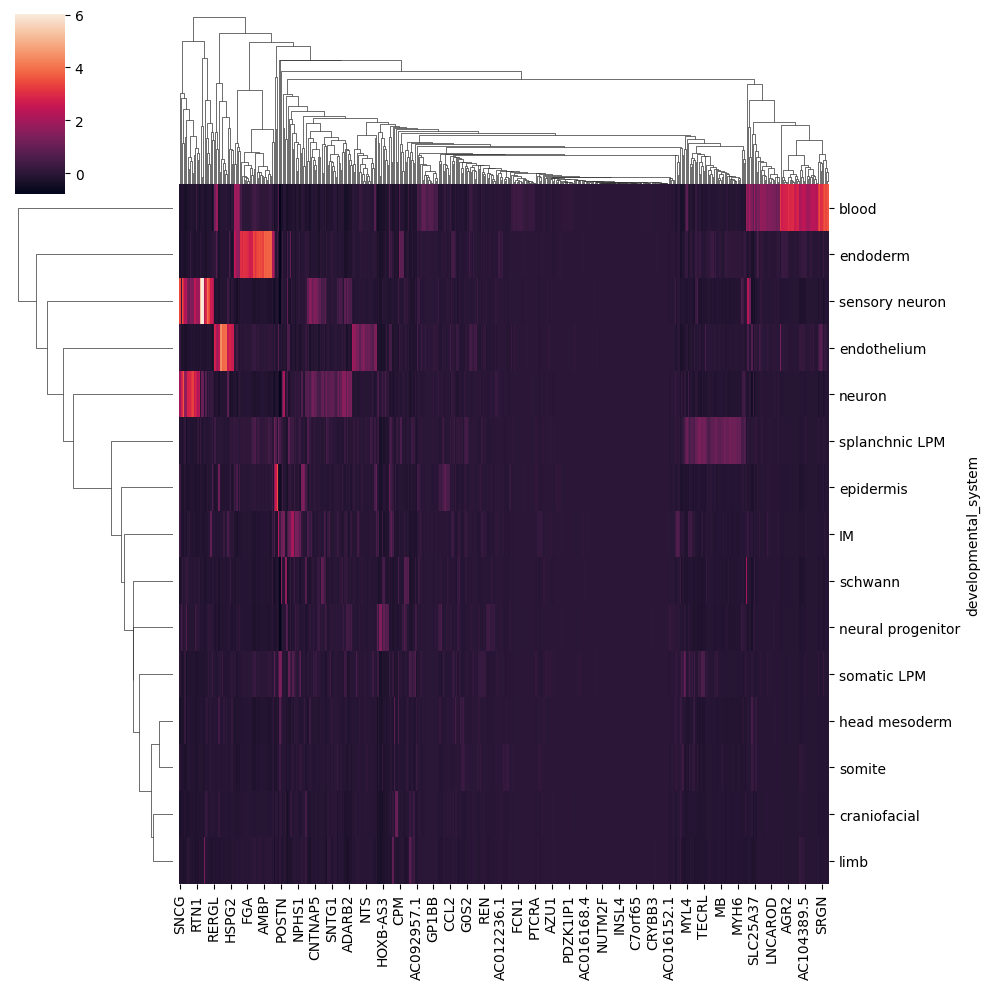

In [13]:
sns.clustermap(agg)